In [1]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
from all_funcs import mod_df
from all_funcs import add_factor
from all_funcs import three_graphs_one_plot
from all_funcs import fac_plots
from all_funcs import cap_outliers_by_list
from all_funcs import find_outliers_IQR
from all_funcs import ult_analysis
from all_funcs import test_mannwhitneyu
from all_funcs import siegel_tukey
from all_funcs import get_corr
from all_funcs import plot_pred
from all_funcs import train_test_split
from all_funcs import series_to_supervised
from all_funcs import pred_val
from all_funcs import graphs
from all_funcs import make_autocorr_plot
from all_funcs import make_autocorr_plot
# from all_funcs import persistence
# from all_funcs import make_forecasts
# from all_funcs import evaluate_forecasts
# from all_funcs import plot_forecasts
# from all_funcs import split_into_sequences
# from all_funcs import get_train_test_sets
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
dfs = []
for name in ['datasets\газпром-капитал.xlsx', 'datasets\газпром-нефть.xlsx' , 'datasets\гсп-финанс.xlsx']:
  dfs.append(mod_df(name))

In [3]:
for i in range(len(dfs)):
  for name in ['datasets/rub-yield-curve-10y (1).xlsx', 'datasets/rucbcp3a3yns.xlsx', 'datasets/usd_rub-(fx) (1).xlsx', 'datasets/ставка-ruonia.xlsx']:
    dfs[i] = add_factor(dfs[i], name)
    dfs[i]['key_0'] = pd.to_datetime(dfs[i]['key_0'])
    dfs[i] = dfs[i].set_index('key_0')

In [4]:
dfs[1].head(3)

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-04-01,84.05,15.6303,313.630611,1,RU000A0ZYLQ4,datasets\газпром-нефть.xlsx,11.3592,92.33,83.25000,19.25
2022-04-02,84.05,15.6303,313.630611,2,RU000A0ZYLQ4,datasets\газпром-нефть.xlsx,11.3592,92.33,85.74953,19.25
2022-04-03,84.05,15.6303,313.630611,3,RU000A0ZYLQ4,datasets\газпром-нефть.xlsx,11.3592,92.33,85.74882,19.25


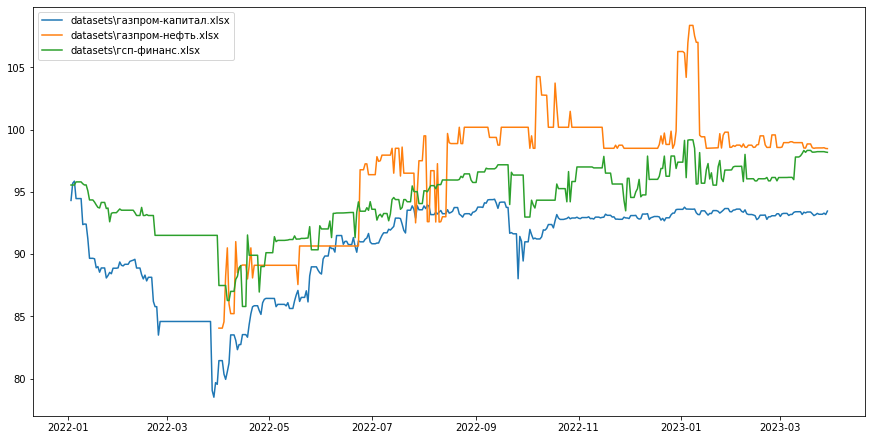

In [5]:
three_graphs_one_plot(dfs[0], dfs[1], dfs[2])

In [6]:
df_alph_full = dfs[0][dfs[0].index >= '2022-05-01']
df_alph_full['t'] = [i for i in range(len(df_alph_full))]

C:\Temp\ipykernel_9068\613649094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alph_full['t'] = [i for i in range(len(df_alph_full))]


In [7]:
df_alph_full.head(2)

,Indicative,YTM Indicative,G-spread,t,ISIN,name,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,,,
2022-05-01,86.44,11.3093,153.798067,0,RU000A101QM3,datasets\газпром-капитал.xlsx,10.3225,95.97,73.35063,16.56
2022-05-02,86.44,11.3093,153.798067,1,RU000A101QM3,datasets\газпром-капитал.xlsx,10.3225,95.97,70.92121,16.56


<AxesSubplot:xlabel='key_0'>

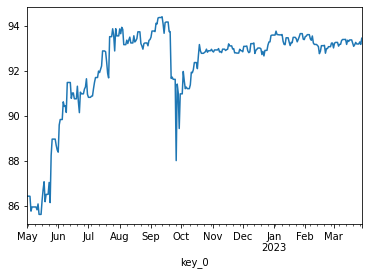

In [8]:
df_alph_full['Indicative'].plot()

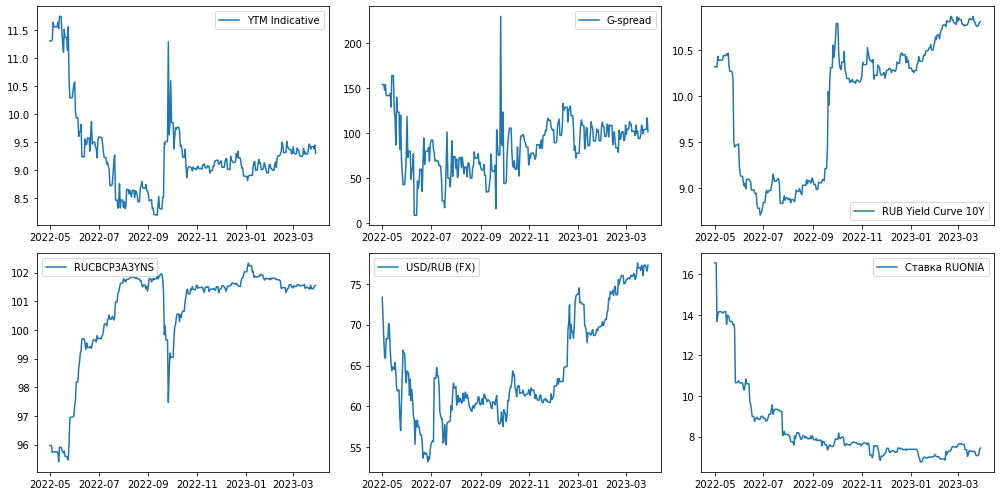

In [9]:
fac_plots(df_alph_full)

In [10]:
df_alph = df_alph_full.copy()

In [11]:
outliers = {}
for name in df_alph.select_dtypes(include = numerics).columns:
  outliers['{}'.format(name)] = find_outliers_IQR(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
  if len(outliers[name]) > 0:
    df_alph[name] = cap_outliers_by_list(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
    df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name] = cap_outliers_by_list(df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name])

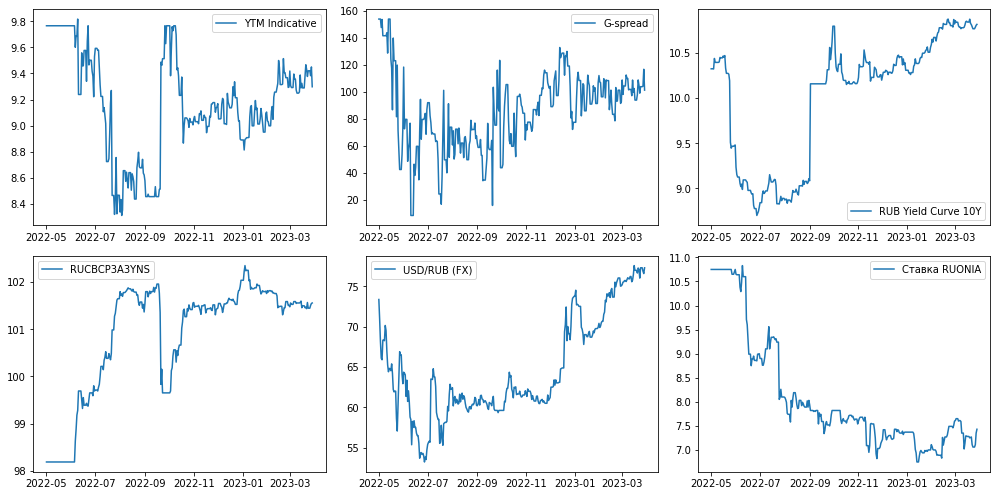

In [12]:
fac_plots(df_alph)

MSE = 0.01879


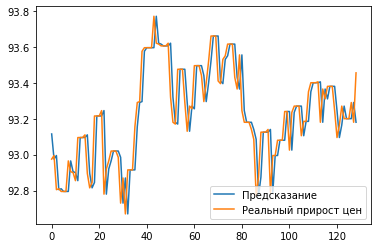

In [13]:
pred_val(df_alph_full['Indicative'][204:], df_alph_full['Indicative'][203:].shift(1).dropna())

MSE = 0.04216


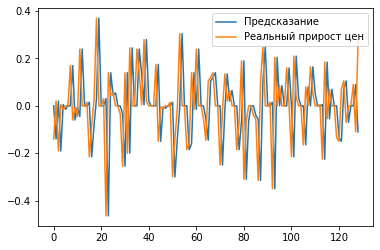

In [80]:
#Тривиальная модель

from sklearn.metrics import mean_squared_error

pred_val((df_alph_full['Indicative'][203:] - df_alph_full['Indicative'][203:].shift(1)).dropna(), (df_alph_full['Indicative'][202:].shift(1) - df_alph_full['Indicative'][202:].shift(2)).dropna())


### Linear models

In [15]:
siegel_tukey(df_alph['Indicative'])
test_mannwhitneyu(df_alph['Indicative'])

z value: -10.719
Probably different distributions
stat=8.61e+03, p=8.61e+03
Probably different distributions


In [16]:
df_alph['Indicative'] = df_alph['Indicative'] - df_alph['Indicative'].shift(1)
df_alph_uni = df_alph[['Indicative', 't']]
df_alph_uni = df_alph_uni[1:]

In [17]:
df_alph_uni.head(3)

,Indicative,t
key_0,,
2022-05-02,0.0,1
2022-05-03,0.0,2
2022-05-04,0.0,3


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_alph_uni['t'], df_alph_uni['Indicative'], 130)

In [19]:
import statsmodels.api as sm

X_lm = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_lm)
regr2 = regr.fit()
print(regr2.summary())

                            OLS Regression Results                            
Dep. Variable:             Indicative   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2253
Date:                Mon, 22 May 2023   Prob (F-statistic):              0.636
Time:                        19:56:43   Log-Likelihood:                -64.596
No. Observations:                 202   AIC:                             133.2
Df Residuals:                     200   BIC:                             139.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0368      0.047      0.779      0.4

MSE = 0.01901


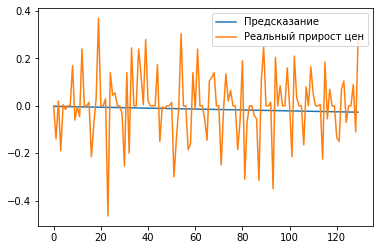

In [20]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression().fit(X_train, y_train)
prediction = regr2.predict(sm.add_constant(X_test))

# print('MSE = %.4g' % mean_squared_error((y_test+df_alph_full['Indicative'][202:].shift(1)[1:]), (prediction+df_alph_full['Indicative'][202:].shift(1)[1:])))

# plot_pred(prediction+df_alph_full['Indicative'][202:].shift(1)[1:], y_test+df_alph_full['Indicative'][202:].shift(1)[1:])

print('MSE = %.4g' % mean_squared_error(y_test, prediction))

plot_pred(prediction, y_test)

### ARIMA

c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


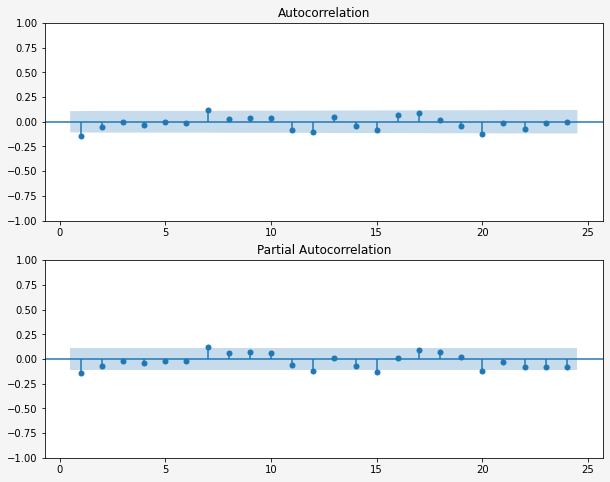

In [21]:
make_autocorr_plot(df_alph_uni['Indicative'])

In [22]:
train = df_alph_uni['Indicative'][:203]
test = df_alph_uni['Indicative'][203:]

In [23]:
arima_model = ARIMA(train, order = (1,0,0))
model = arima_model.fit()
print(model.summary())

c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Indicative   No. Observations:                  203
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -62.467
Date:                Mon, 22 May 2023   AIC                            130.933
Time:                        19:56:44   BIC                            140.873
Sample:                    05-02-2022   HQIC                           134.955
                         - 11-20-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0173      0.022      0.801      0.423      -0.025       0.060
ar.L1         -0.1415      0.076     -1.867      0.062      -0.290       0.007
sigma2         0.1083      0.004     26.274      0.0

MSE = 0.01901


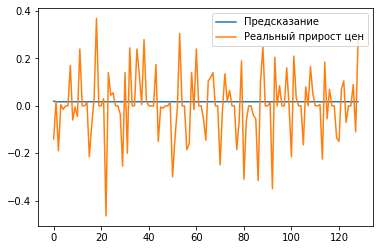

In [24]:
prediction = model.forecast(129)

print('MSE = %.4g' % mean_squared_error(test, prediction))

plot_pred(prediction, test)

### LSTM

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
 names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 if i == 0:
  names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
  names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg


def persistence(last_ob, n_seq):
 return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
                
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		plt.plot(xaxis, forecasts[i], color='red')
	# show the plot
	plt.show()

In [26]:
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
price = df_alph_full['Indicative'].values.reshape(-1, 1)
scaled_price = scaler.fit_transform(price)

In [35]:
seq_len = 60

# x_train, y_train, x_test, y_test = get_train_test_sets(scaled_price, seq_len, train_frac=0.9)
x_train, y_train, x_test, y_test = get_train_test_sets(df_alph['Indicative'][1:].values.reshape(-1, 1), seq_len, train_frac=0.525)


In [36]:
len(y_test)

130

In [37]:
# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [38]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
8/8 [==============================] - 12s 492ms/step - loss: 0.1514 - val_loss: 0.0072
Epoch 2/10
8/8 [==============================] - 1s 160ms/step - loss: 0.1505 - val_loss: 0.0089
Epoch 3/10
8/8 [==============================] - 2s 185ms/step - loss: 0.1505 - val_loss: 0.0107
Epoch 4/10
8/8 [==============================] - 1s 129ms/step - loss: 0.1507 - val_loss: 0.0215
Epoch 5/10
8/8 [==============================] - 1s 144ms/step - loss: 0.1482 - val_loss: 0.0344
Epoch 6/10
8/8 [==============================] - 1s 112ms/step - loss: 0.1476 - val_loss: 0.0608
Epoch 7/10
8/8 [==============================] - 1s 117ms/step - loss: 0.1468 - val_loss: 0.0617
Epoch 8/10
8/8 [==============================] - 1s 126ms/step - loss: 0.1473 - val_loss: 0.0623
Epoch 9/10
8/8 [==============================] - 1s 148ms/step - loss: 0.1440 - val_loss: 0.0450
Epoch 10/10
8/8 [==============================] - 1s 122ms/step - loss: 0.1431 - val_loss: 0.0542


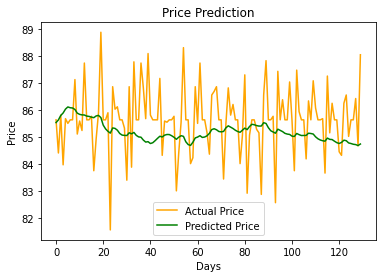

In [39]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
 
plt.title('Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

MSE = 0.02245


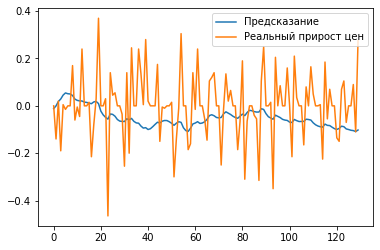

In [40]:
pred_val(y_test, y_pred)

### Multivariate models

In [41]:
df_alph = df_alph_full.copy()
df_alph = df_alph.select_dtypes(include=numerics)

In [42]:
df_alph.head(5)

,Indicative,YTM Indicative,G-spread,t,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,
2022-05-01,86.440,11.3093,153.798067,0,10.3225,95.97,73.35063,16.56
2022-05-02,86.440,11.3093,153.798067,1,10.3225,95.97,70.92121,16.56
2022-05-03,86.440,11.3093,153.798067,2,10.3225,95.97,68.13433,16.56
2022-05-04,86.435,11.3349,147.539172,3,10.3203,95.73,66.08850,13.68
2022-05-05,85.775,11.6414,153.500940,4,10.4369,95.75,65.88899,14.00


In [43]:
outliers = {}
for name in df_alph.select_dtypes(include = numerics).columns:
  outliers['{}'.format(name)] = find_outliers_IQR(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
  if len(outliers[name]) > 0:
    df_alph[name] = cap_outliers_by_list(df_alph[name])

for name in df_alph.select_dtypes(include = numerics).columns:
    df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name] = cap_outliers_by_list(df_alph.loc[df_alph[('2022-09'<df_alph.index) & (df_alph.index<='2022-12')].index, name])

In [44]:
# df_alph['Indicative'] = np.exp(df_alph['Indicative'])
# for name in df_alph.columns:
#     df_alph[name] = np.log(df_alph[name])
# df_alph['YTM Indicative'] = np.log(df_alph['YTM Indicative'])
# df_alph['USD/RUB (FX)'] = np.log(df_alph['USD/RUB (FX)'])
# df_alph['Ставка RUONIA'] = np.log(df_alph['Ставка RUONIA'])


In [45]:
df_alph = (df_alph - df_alph.shift(1)).dropna()

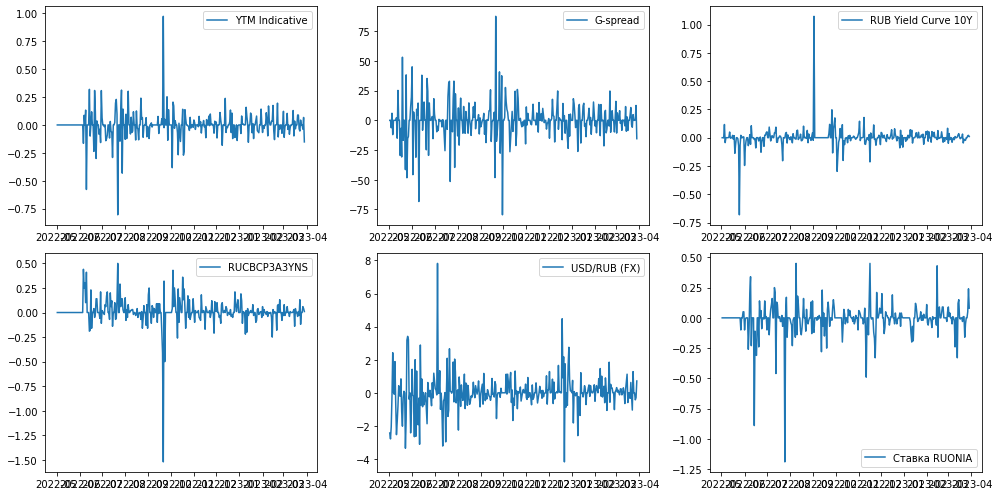

In [46]:
fac_plots(df_alph)

In [47]:
df_alph['t'] = [i for i in range(len(df_alph))]

In [48]:
df_alph

,Indicative,YTM Indicative,G-spread,t,RUB Yield Curve 10Y,RUCBCP3A3YNS,USD/RUB (FX),Ставка RUONIA
key_0,,,,,,,,
2022-05-02,0.000,0.0000,0.000000,0,0.0000,0.00,-2.42942,0.00
2022-05-03,0.000,0.0000,0.000000,1,0.0000,0.00,-2.78688,0.00
2022-05-04,0.000,0.0000,-6.258895,2,-0.0022,0.00,-2.04583,0.00
2022-05-05,0.000,0.0000,5.961768,3,0.1166,0.00,-0.19951,0.00
2022-05-06,0.000,0.0000,-12.037112,4,-0.0436,0.00,2.42426,0.00
...,...,...,...,...,...,...,...,...
2023-03-25,0.000,0.0000,0.000000,327,0.0000,0.00,0.00000,0.00
2023-03-26,0.000,0.0000,0.000000,328,0.0000,0.00,0.00000,0.00
2023-03-27,0.090,-0.0378,0.386803,329,0.0176,0.06,-0.42570,0.05


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2022-05-02 to 2023-03-29
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Indicative           332 non-null    float64
 1   YTM Indicative       332 non-null    float64
 2   G-spread             332 non-null    float64
 3   t                    332 non-null    int64  
 4   RUB Yield Curve 10Y  332 non-null    float64
 5   RUCBCP3A3YNS         332 non-null    float64
 6   USD/RUB (FX)         332 non-null    float64
 7   Ставка RUONIA        332 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 23.3 KB
None
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 1
Indicative             0
YTM Indicative         0
G-spread               0
t                      0
RUB Yield Curve 10Y    0
RUCBCP3A3YNS           0
USD/RUB (FX)           0
Ставка RUONIA          0
dtype: int64
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

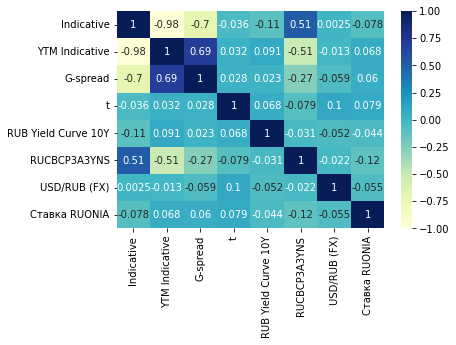

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 4
key_0
2022-06-03    0.240
2022-06-06    0.785
2022-06-07   -0.190
2022-06-09   -0.295
2022-06-10    1.330
              ...  
2023-03-01   -0.215
2023-03-02    0.210
2023-03-06   -0.165
2023-03-14   -0.225
2023-03-29    0.275
Name: Indicative, Length: 90, dtype: float64
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 5


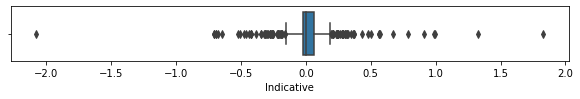

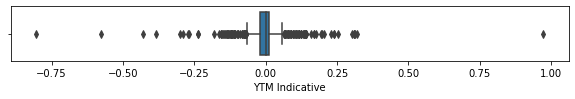

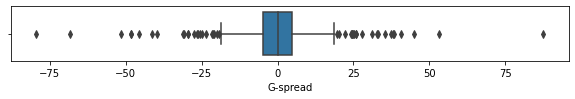

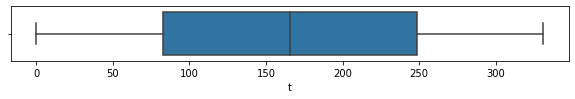

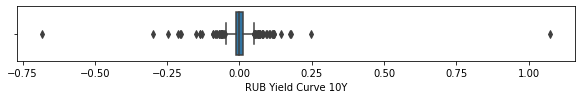

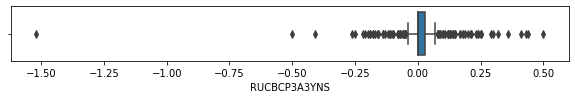

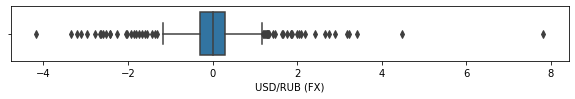

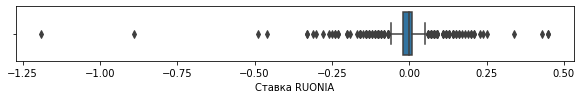

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 6


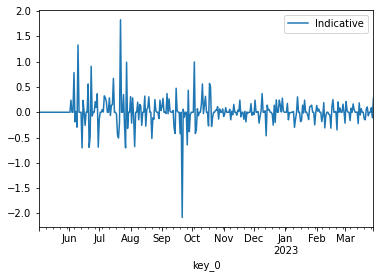

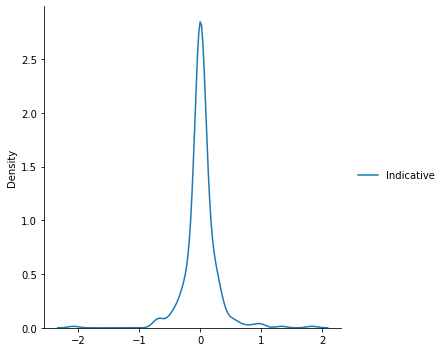

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 7
Тест Jarque Bera
        JB        p-value         skew              kurtosis     
-----------------------------------------------------------------
4381.476826689639     0.0 0.060341957388913896 20.796592369683804
-----------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.741, p-value=0.000
Отклонить гипотезу о нормальности
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 8
Тест Jarque Bera
        JB        p-value         skew              kurtosis     
-----------------------------------------------------------------
4381.476826689639     0.0 0.060341957388913896 20.796592369683804
-----------------------------------------------------------------

Тест Шапиро-Уилк
Statistics=0.741, p-value=0.000
Отклонить гипотезу о нормальности
None


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


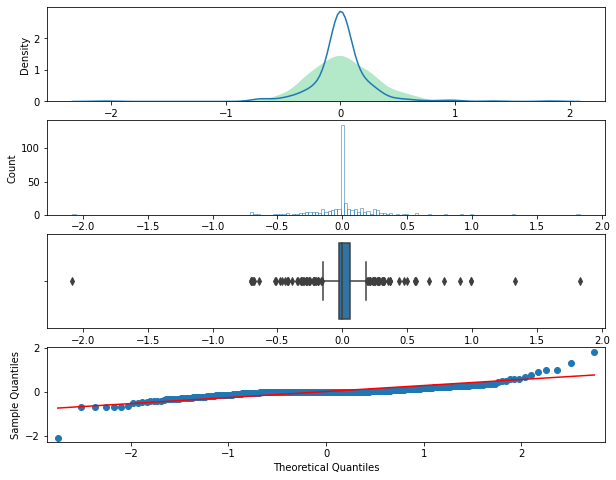

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 9


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


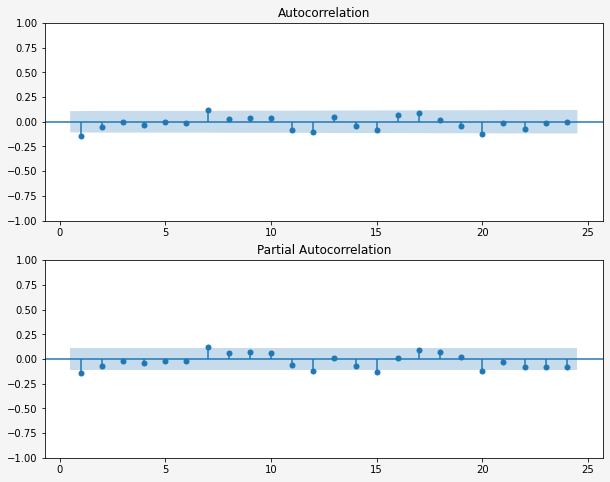

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 10
Тестирование средних. Статистика Стьюдента: 0.02629839732910875. Критическое значение: 1.6541409762941324
Тестирование дисперсий. Статистика Фишера: 0.15497235071282398. Критическое значение: 1.2928419282151524
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ - 11
excess kurtosis of normal distribution (should be 0): 17.796592369683804
skewness of normal distribution (should be 0): 0.060341957388913896


In [49]:
ult_analysis(df_alph)

In [50]:
siegel_tukey(df_alph['Indicative'])
test_mannwhitneyu(df_alph['Indicative'])

z value: 0.568
Probably the same distribution
stat=1.39e+04, p=1.39e+04
Probably the same distribution


C:\Temp\ipykernel_9068\3445508651.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0


<AxesSubplot:>

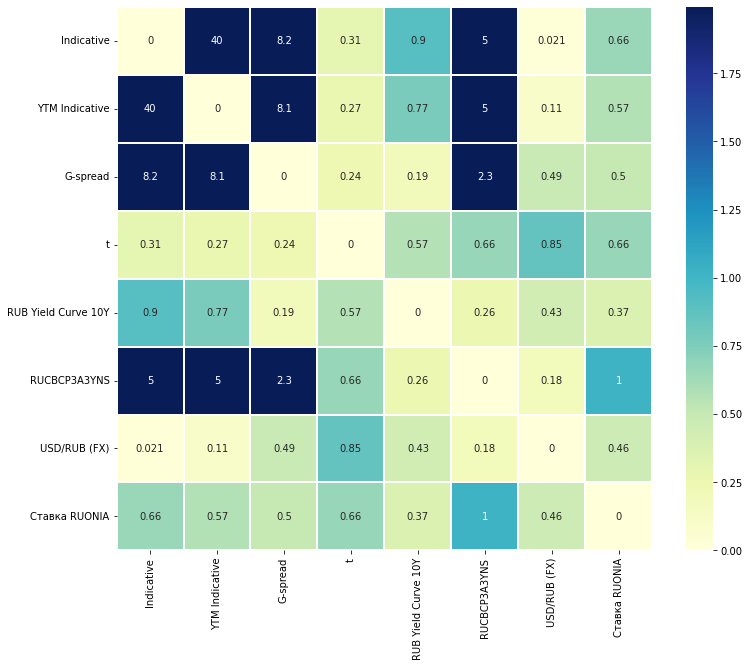

In [51]:
corrmat = df_alph.corr(method='pearson')

corrmat_significance = np.abs(corrmat/np.sqrt(1-np.power(corrmat,2))*np.sqrt(70))
corrmat_significance.values[[np.arange(corrmat_significance.shape[0])]*2] = 0

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat_significance, ax=ax, cmap="YlGnBu", linewidths=0.1, annot=True, vmax=1.994)

### Feature selection

In [52]:
X = df_alph.drop('Indicative', axis = 1).select_dtypes(include=numerics)
Y = df_alph['Indicative']

In [53]:
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X, Y)
set_printoptions(precision=3)
print(fit.scores_)

[123.921   2.358   0.869   2.724   6.923   0.763   2.839]


In [54]:
X.columns

Index(['YTM Indicative', 'G-spread', 't', 'RUB Yield Curve 10Y',
       'RUCBCP3A3YNS', 'USD/RUB (FX)', 'Ставка RUONIA'],
      dtype='object')

In [55]:
alph_feat = df_alph[['Indicative', 'YTM Indicative', 'G-spread', 'RUCBCP3A3YNS']]

## Modeling

### Random forest

In [56]:
X = alph_feat.drop('Indicative', axis = 1)
y = alph_feat['Indicative']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 130)

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args

n_features = X.shape[1]

reg = XGBRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4], res_gp.x[5]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Best score=0.0497
Best parameters:
- max_depth=1
- learning_rate=0.144769
- max_features=3
- min_samples_split=2
- min_samples_leaf=1
- n_estimators=73


MSE = 0.001483


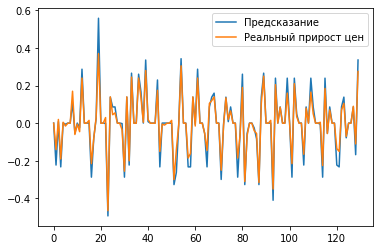

In [74]:

regressor = XGBRegressor(max_depth=1, learning_rate=0.144769, max_features=3, min_samples_split=2, min_samples_leaf=1, n_estimators=73)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [60]:
n_features = X.shape[1]

reg = RandomForestRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\opt

Best score=0.0517
Best parameters:
- max_depth=5
- max_features=3
- min_samples_split=2
- min_samples_leaf=1
- n_estimators=100


MSE = 0.001644


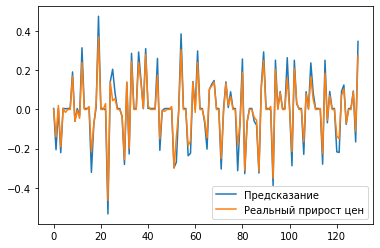

In [75]:

regressor = RandomForestRegressor(max_depth=5, max_features=3, min_samples_split=2, min_samples_leaf=1, n_estimators=100)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [62]:
# X = df_alph_full[['Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'USD/RUB (FX)']].drop('Indicative', axis = 1)
# y = df_alph_full[['Indicative', 'G-spread', 'RUB Yield Curve 10Y', 'USD/RUB (FX)']]['Indicative'] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, 130)

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

n_features = X.shape[1]

reg = GradientBoostingRegressor(n_estimators=50, random_state=0)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4], res_gp.x[5]))


Best score=0.0498
Best parameters:
- max_depth=1
- learning_rate=0.104006
- max_features=3
- min_samples_split=83
- min_samples_leaf=1
- n_estimators=94


MSE = 0.001477


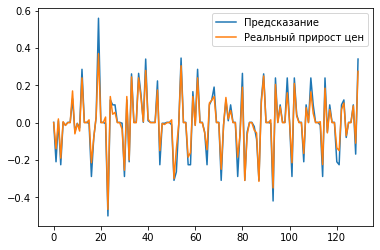

In [76]:

regressor = GradientBoostingRegressor(max_depth=1, learning_rate=0.104006, max_features=3, min_samples_split=83, min_samples_leaf=1, n_estimators=94)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [65]:
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor()
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2]))


Best score=0.0490
Best parameters:
- max_depth=1
- learning_rate=0.092690
- min_samples_leaf=1


MSE = 0.001422


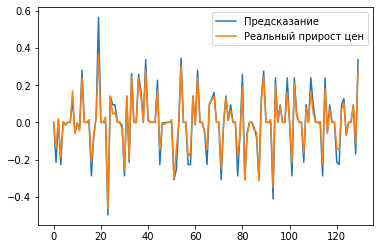

In [77]:
regressor = HistGradientBoostingRegressor(max_depth=1, learning_rate=0.092690, min_samples_leaf=1)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [67]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(loss = 'linear')
space  = [Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- learning_rate=%.6f
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1]))


c:\Users\jama2\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=0.0603
Best parameters:
- learning_rate=0.000347
- n_estimators=100


MSE = 0.002824


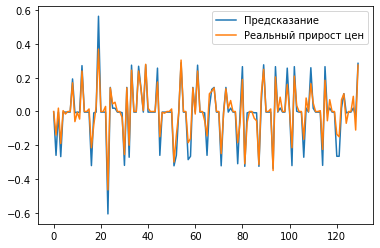

In [78]:
regressor = AdaBoostRegressor(loss = 'linear', learning_rate=0.000347, n_estimators=100)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

In [69]:
from lineartree           import LinearBoostRegressor

reg = LinearBoostRegressor(base_estimator=LinearRegression(), loss = 'linear')
space  = [Integer(1, 5, name='max_depth'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf'),
          Integer(2, 100, name='n_estimators')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train,  cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("Best score=%.4f" % res_gp.fun)

print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d
- n_estimators=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))

Best score=0.0288
Best parameters:
- max_depth=4
- max_features=3
- min_samples_split=4
- min_samples_leaf=55
- n_estimators=100


MSE = 0.002675


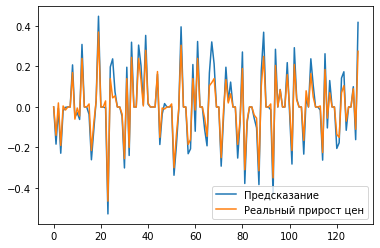

In [79]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 max_depth=4, max_features=3, min_samples_split=4, min_samples_leaf=55, n_estimators=100)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

pred_val(y_test, predictions)

### Метод главных компонент

In [71]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

#для удобства создадим датафрейм без столбца даты и целевого значения

df11 = df_alph.loc[:, df_alph.columns!='Indicative'].select_dtypes(include=numerics)

#для работы методом главных компонент необходимо нормализировать данные

df1 = preprocessing.normalize(df11)
df1 = pd.DataFrame(df1, columns = df11.columns)

[0.767 1.    1.    1.    1.    1.   ]


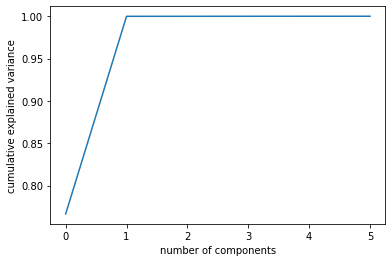

In [72]:
pca = PCA().fit(df1.drop('USD/RUB (FX)', axis = 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print(np.cumsum(pca.explained_variance_ratio_))

In [73]:
df_alph[1:]['Indicative']

key_0
2022-05-03    0.000
2022-05-04    0.000
2022-05-05    0.000
2022-05-06    0.000
2022-05-07    0.000
              ...  
2023-03-25    0.000
2023-03-26    0.000
2023-03-27    0.090
2023-03-28   -0.110
2023-03-29    0.275
Name: Indicative, Length: 331, dtype: float64